In [96]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [97]:
class ReplayBuffer:
    def __init__(self, capacity) -> None:
        self.buffer = collections.deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done
    
    def size(self):
        return len(self.buffer)


In [98]:
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, *args, **kwargs) -> None:
        super(Qnet, self).__init__(*args, **kwargs)
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 256)
        self.fc3 = torch.nn.Linear(256, 512)
        self.fc4 = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        return x

In [99]:
class DQN:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, epsilon, target_update, device) -> None:
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)

        self.target_q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)

        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr = learning_rate)

        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值

        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

    def predict_action(self, state):
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        q_value = self.target_q_net.forward(state)
        return torch.argmax(q_value)

In [105]:
lr = 2e-3
num_episodes = 5000
hidden_dim = 128
gamma = 0.99
epsilon = 0.01
target_update = 5
buffer_size = 10000
minimal_size = 500
batch_size = 128
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name, render_mode = 'human')
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
for i in range(100):
    with tqdm(total=int(num_episodes / 100), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 100)):
            episode_return = 0
            state = env.reset()[0]
            done = False
            while not done:
                # print(state)
                env.render()
                action = agent.take_action(state)
                next_state, reward, done, _, _ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 100 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 0:  74%|███████▍  | 37/50 [01:15<01:42,  7.87s/it, episode=30, return=16.600]

In [ ]:
import time

env_name = 'CartPole-v0'
env = gym.make(env_name, render_mode = 'human')
state = env.reset()[0]
done = False
while not done:
    time.sleep(1 / 75)
    env.render()
    action = agent.predict_action(state)
    print(action.item())
    state, _, done, _, _ = env.step(action.item())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


1
1
0
1
0
1
0
1
0
0
1
0
1
0
1
0
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
1
0
0
1
0
1
1
0
0
1
0
1
0
1
0
1
1
0
0
1
0
1
1
0
0
1
0
1
0
1
1
0
0
1
0
1
1
0
0
1
0
1
0
1
1
0
0
1
0
1
1
0
0
1
0
1
1
0
0
1
0
1
0
1
1
0
0
1
0
1
0
1
1
0
0
1
0
1
1
0
0
1
0
1
0
1
1
0
0
1
0
1
0
1
1
0
0
1
0
1
1
0
0
1
0
1
0
1
1
0
0
1
0
1
0
1
1
0
0
1
0
1
0
1
1
0
0
1
0
1
1
0
0
1
0
1
0
1
1
0
0
1
0
1
0
1
0
1
1
0
0
1
0
1
0
1
1
0
0
1
0
1
0
1
1
0
0
1
0
1
0
1
0
1
1
0
0
1
0
1
0
1
0
1
0
1
1
0
0
1
0
1
0
1
0
1
0
1
0
1
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
0
1
0
1
0
1
0
1
0
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
0
1
0
1
0
1
0
1
0
0
1
0
1
0
1
0
0
1
0
1
0
1
0
0
1
0
1
0
1
0
0
1
0
1
0
1
0
0
1
0
1
0
0
1
0
1
0
0
0
1
0
1
0
0


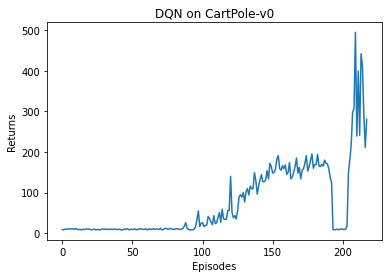

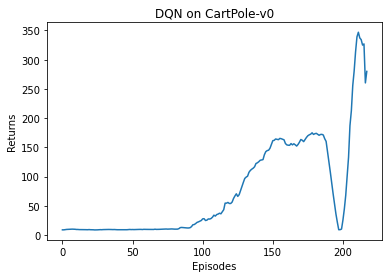

In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()